In [1]:
from pathlib import Path
from itertools import product

import numpy as np
import healpy as hp
from sklearn.decomposition import PCA
from astropy.io import fits

import matplotlib.pyplot as plt
import matplotlib.transforms as transforms

from tqdm import tqdm  # For progress bars

from handle_data import get_map_dtype, get_planck_obs_data, get_planck_noise_data

In [2]:
import logging

In [3]:
logger = logging.getLogger("handle_data")
logger.setLevel(logging.DEBUG)

In [4]:
DATA_ROOT = "/data/jim/CMB_Data/"
ASSETS_DIRECTORY = f"{DATA_ROOT}/Assets/Planck/"
PLANCK_NOISE_DIR = f"{DATA_ROOT}/Planck_Noise/"

DETECTORS = [30, 44, 70, 100, 143, 217, 353, 545, 857]
N_PLANCK_SIMS = 50

In [5]:
def get_lmax_for_nside(nside):
    """Helper function: Max ell for a given nside; to be considered a parameter"""
    return 3 * nside - 1

# Setup

# Planck Sims

In [6]:
# combos = product(DETECTORS, range(N_PLANCK_SIMS))

# for det, sim_num in combos:
#     src_map_fn = get_planck_noise_data(detector=det, 
#                                        assets_directory=ASSETS_DIRECTORY, 
#                                        realization=sim_num, 
#                                        progress=True)
# print("All maps acquired!")

In [7]:
# def get_ps_data(detector):
#     if detector in [30, 44, 70]:
#         nside = 1024
#     else:
#         nside = 2048
#     lmax = get_lmax_for_nside(nside)  # Defined above as 3*Nside-1
#     # Getting power spectra for 100 maps at 100 GHz takes ~50 minutes
#     src_cls = []
#     for i in tqdm(range(N_PLANCK_SIMS)):
#         src_map_fn = get_planck_noise_data(detector=detector, assets_directory=ASSETS_DIRECTORY, realization=i, progress=True)
#         t_src_map = hp.read_map(src_map_fn) * 1e6
#         src_cls.append(hp.anafast(t_src_map, lmax=lmax))

#     # Determine parameters for approximating the distribution

#     # Use log scaling for the power spectra; otherwise it's dominated by low ells
#     log_src_cls = np.log10(src_cls)

#     # We want to find the components that explain the majority of the variance
#     #   We don't have enough maps to fully determine the distribution, but a full
#     #   covariance matrix is overkill anyways. PCA gives a good, concise summary.
#     pca = PCA().fit(log_src_cls)

#     # We need the mean, the components (eigenvectors), and the variance (eigenvalues)
#     #   These are surrogates for the full covariance matrix
#     mean_ps = pca.mean_
#     components = pca.components_  
#     variance = pca.explained_variance_

#     # Save the results; delete the variables so we know we test loading them
#     np.savez(f"noise_pca_{detector}GHz.npz", mean=mean_ps, components=components, variance=variance)

In [8]:
# # Takes 3 hours for 50 maps and all detectors
# for det in DETECTORS:
#     get_ps_data(det)

In [ ]:

def get_field_unit(fits_fn, hdu, field_idx):
    """
    Get the unit associated with a specific field from the header of the 
    specified HDU (Header Data Unit) in a FITS file.

    Args:
        fits_fn (str): The filename of the FITS file.
        hdu (int): The index of the HDU.
        field_idx (int): The index of the field.

    Returns:
        str: The unit of the field.
    """
    with fits.open(fits_fn) as hdul:
        try:
            field_num = field_idx + 1
            unit = hdul[hdu].header[f"TUNIT{field_num}"]
        except KeyError:
            unit = ""
    return unit

In [9]:
def get_ps_data(detector):
    if detector in [30, 44, 70]:
        nside = 1024
    else:
        nside = 2048
    lmax = get_lmax_for_nside(nside)  # Defined above as 3*Nside-1
    # Getting power spectra for 100 maps at 100 GHz takes ~50 minutes
    src_cls = []
    maps_means = []
    for i in tqdm(range(N_PLANCK_SIMS)):
        src_map_fn = get_planck_noise_data(detector=detector, assets_directory=ASSETS_DIRECTORY, realization=i, progress=True)
        t_src_map = hp.read_map(src_map_fn) * 1e6
        maps_means.append(np.mean(t_src_map))
        src_cls.append(hp.anafast(t_src_map, lmax=lmax))

    # Determine parameters for approximating the distribution of power spectra
    # Use log scaling for the power spectra; otherwise it's dominated by low ells
    log_src_cls = np.log10(src_cls)

    # We want to find the components that explain the majority of the variance
    #   We don't have enough maps to fully determine the distribution, but a full
    #   covariance matrix is overkill anyways. PCA gives a good, concise summary.
    pca = PCA().fit(log_src_cls)

    # We need the mean, the components (eigenvectors), and the variance (eigenvalues)
    #   These are surrogates for the full covariance matrix
    mean_ps = pca.mean_
    components = pca.components_  
    variance = pca.explained_variance_

    # We need the mean and standard deviation of the maps_means so we can adjust the monopole as needed
    maps_mean = np.mean(maps_means)
    maps_sd = np.std(maps_means)

    # Save the results; delete the variables so we know we test loading them
    np.savez(f"noise_model_{detector}GHz.npz", mean_ps=mean_ps, components=components, variance=variance, maps_mean=maps_mean, maps_sd=maps_sd)

In [10]:
def get_map_mean(detector):
    means = []
    for i in tqdm(range(N_PLANCK_SIMS)):
        src_map_fn = get_planck_noise_data(detector=detector, assets_directory=ASSETS_DIRECTORY, realization=i, progress=True)
        t_src_map = hp.read_map(src_map_fn) * 1e6
        means.append(np.mean(t_src_map))

    mean = np.mean(means)
    sd = np.std(means)
    return mean, sd

In [11]:
from astropy.io import fits

def get_field_unit(fits_fn, hdu, field_idx):
    """
    Get the unit associated with a specific field from the header of the 
    specified HDU (Header Data Unit) in a FITS file.

    Args:
        fits_fn (str): The filename of the FITS file.
        hdu (int): The index of the HDU.
        field_idx (int): The index of the field.

    Returns:
        str: The unit of the field.
    """
    with fits.open(fits_fn) as hdul:
        try:
            field_num = field_idx + 1
            unit = hdul[hdu].header[f"TUNIT{field_num}"]
        except KeyError:
            unit = ""
    return unit

In [12]:
def get_unit(detector):
    src_map_fn = get_planck_noise_data(detector=detector, assets_directory=ASSETS_DIRECTORY, realization=0, progress=True)
    mu = get_field_unit(src_map_fn, 1, 0)
    return mu

In [13]:
get_unit(30)

'K_CMB'

In [14]:
for this_det in DETECTORS:
    _m, _sd = get_map_mean(this_det)
    print(_m, _sd)
    map_unit = get_unit(this_det)
    np.savez(f"noise_mean_{this_det}GHz.npz", mean=_m, sd=_sd, map_unit=map_unit)

100%|██████████| 50/50 [01:18<00:00,  1.58s/it]


15.939296 0.22290839


100%|██████████| 50/50 [01:17<00:00,  1.56s/it]


14.381222 0.27000186


100%|██████████| 50/50 [01:19<00:00,  1.58s/it]


14.484065 0.27775952


100%|██████████| 50/50 [03:00<00:00,  3.60s/it]


0.9152881 0.7097808


100%|██████████| 50/50 [03:09<00:00,  3.79s/it]


-0.3112331 0.33107635


100%|██████████| 50/50 [03:16<00:00,  3.93s/it]


-0.7275943 1.2735462


100%|██████████| 50/50 [03:19<00:00,  3.98s/it]


-10.550626 6.3573728


100%|██████████| 50/50 [01:19<00:00,  1.59s/it]


-7847.94 53.799576


100%|██████████| 50/50 [01:20<00:00,  1.61s/it]

-4751.6924 71.41619


In [16]:
for this_det in DETECTORS:
    pca_data = np.load(f"noise_pca_{this_det}GHz.npz")
    maps_data = np.load(f"noise_mean_{this_det}GHz.npz")

    mean_ps     = pca_data['mean']
    components  = pca_data['components']
    variance    = pca_data['variance']

    mean_maps   = maps_data['mean']
    sd_maps     = maps_data['sd']
    map_unit    = maps_data['map_unit']

    np.savez(f"noise_model_{this_det}GHz_n50.npz",
             mean_ps=mean_ps,
             components=components,
             variance=variance,
             mean_maps=mean_maps,
             sd_maps=sd_maps,
             map_unit=map_unit,
             sim_ns=np.arange(0,50))

In [23]:
this_det = 30
_m, _sd = get_map_mean(30)
print(_m, _sd)
map_unit = get_unit(30)
np.savez("noise_mean_30GHz.npz", mean=_m, sd=_sd, map_unit=map_unit)

In [16]:
_m, _sd = get_map_mean(44)
print(_m, _sd)

100%|██████████| 50/50 [01:12<00:00,  1.45s/it]

14.381222 0.27000186


In [18]:
_m, _sd = get_map_mean(70)
print(_m, _sd)

100%|██████████| 50/50 [01:18<00:00,  1.56s/it]

14.484065 0.27775952


In [19]:
_m, _sd = get_map_mean(100)
print(_m, _sd)

100%|██████████| 50/50 [03:31<00:00,  4.23s/it]

0.9152881 0.7097808


In [29]:
_m, _sd = get_map_mean(143)
print(_m, _sd)

100%|██████████| 50/50 [03:16<00:00,  3.93s/it]

-0.3112331 0.33107635


100%|██████████| 50/50 [03:46<00:00,  4.52s/it]

-0.7275943 1.2735462


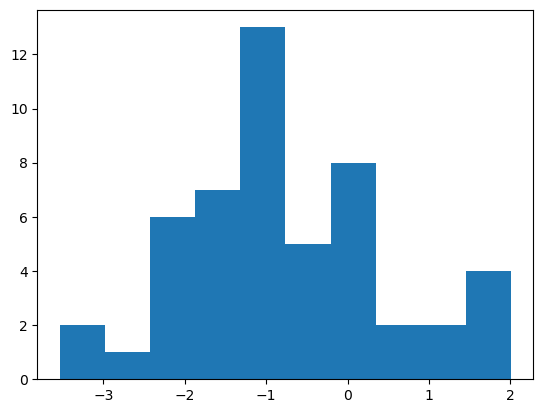

In [29]:
_m, _sd, _means = get_map_mean(217)
print(_m, _sd)
plt.hist(_means, bins=10);

In [24]:
_m, _sd, _means = get_map_mean(353)
print(_m, _sd)
plt.hist(_means, bins=10);

100%|██████████| 50/50 [03:19<00:00,  3.98s/it]

-10.550626 6.3573728


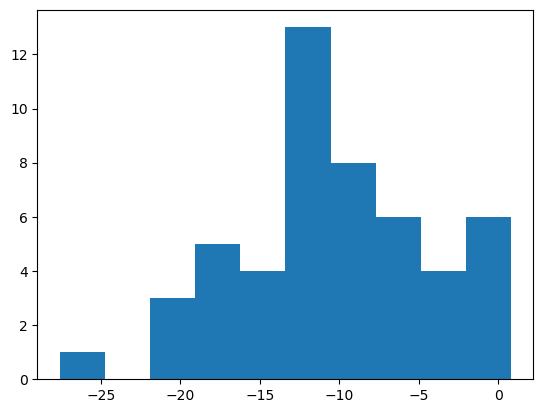

In [28]:
plt.hist(_means, bins=10);

In [32]:
_m, _sd = get_map_mean(545)
print(_m, _sd)

100%|██████████| 50/50 [01:21<00:00,  1.63s/it]

-7847.94 53.799576


In [33]:
_m, _sd = get_map_mean(857)
print(_m, _sd)

 98%|█████████▊| 49/50 [01:20<00:01,  1.90s/it]

100%|██████████| 50/50 [01:37<00:00,  1.95s/it]

-4751.6924 71.41619
